In [134]:
from readlif.reader import LifFile
import os
import numpy as np
import tifffile
from skimage.transform import resize

def convert_lif_to_tiff_hyperstack(lif_file_path, output_base_dir, scalefactor=1):
    """
    Convert a LIF file to multipage TIFF files organized by image and tile.
    Each TIFF is saved as a proper hyperstack with separate dimensions for 
    channels and z-slices that ImageJ can directly recognize. The images are 
    also downscaled by a factor of 0.5.
    
    Args:
        lif_file_path (str): Path to the LIF file
        output_base_dir (str): Base directory to save the output
    """
    # Load the LIF file
    lif_file = LifFile(lif_file_path)
    
    # Get the filename without extension for naming the output folders
    file_name = os.path.splitext(os.path.basename(lif_file_path))[0]
    base_output_dir = os.path.join(output_base_dir, file_name)
    
    # Process each image in the LIF file
    for image_idx in range(lif_file.num_images):
        print(image_idx)
        # Get the image
        image = lif_file.get_image(image_idx)
        image.channel_as_second_dim = False
        
        # Create a directory for this image
        image_name = image.name if image.name else f"Image_{image_idx}"
        image_dir = os.path.join(base_output_dir, image_name)
        os.makedirs(image_dir, exist_ok=True)
        
        # Get the number of channels
        num_channels = image.channels
        
        print(f"Processing Image {image_idx}: {image_name}")
        print(f"  Dimensions: z={image.dims.z}, t={image.dims.t}, channels={num_channels}, m={image.dims.m}")
        
        # Process each mosaic tile
        for m in range(image.dims.m):
            try:
                print(f"  Processing tile {m}")
                
                # First, get sample frame to determine dimensions
                sample_frame = None
                for z in range(image.dims.z):
                    for c in range(num_channels):
                        try:
                            sample_frame = image.get_frame(z=z, t=0, c=c, m=m)
                            if sample_frame is not None:
                                break
                        except Exception:
                            pass
                    if sample_frame is not None:
                        break
                
                if sample_frame is None:
                    print(f"  Warning: Could not get any valid frames for tile {m}")
                    continue
                
                # Get dimensions from sample frame
                width, height = sample_frame.size
                new_width, new_height = width // (scalefactor/1), height // (scalefactor/1)  # Downscale by 0.5
                
                # Debug: print frame size
                print(f"  Original size: {width} x {height}, Downscaled size: {new_width} x {new_height}")
                
                # Create a list to collect images for each channel and z-slice
                channels_data = []
                
                # For each channel
                for c in range(num_channels):
                    channel_frames = []
                    
                    # For each z-slice
                    for z in range(image.dims.z):
                        try:
                            # Get the frame for this specific channel and z-slice
                            frame = image.get_frame(z=z, t=0, c=c, m=m)
                            
                            # Convert to numpy array (preserving original dtype)
                            frame_array = np.array(frame, dtype=np.uint8)  # Keep original intensity range
                            
                            # Downscale the image with preserve_range=True
                            downscaled_frame = resize(
                                frame_array, 
                                (new_height, new_width), 
                                mode="reflect", 
                                anti_aliasing=True,
                                preserve_range=True  # Keep intensity values unchanged
                            ).astype(np.uint8)  # Convert back to 16-bit (or original dtype)
                            
                            channel_frames.append(downscaled_frame)
                        except Exception as e:
                            print(f"  Warning: Error processing z={z}, c={c}, m={m}: {e}")
                            # Create an empty frame with the downscaled dimensions
                            empty_frame = np.zeros((new_height, new_width), dtype=np.uint8)
                            channel_frames.append(empty_frame)
                    
                    # Stack all z-slices for this channel
                    if channel_frames:
                        channel_stack = np.stack(channel_frames)
                        channels_data.append(channel_stack)
                
                # Check if we have data for all channels
                if len(channels_data) != num_channels:
                    print(f"  Warning: Expected {num_channels} channels but got {len(channels_data)}")
                
                # Stack all channels to create the final hyperstack
                # This should be a 4D array: [channels, z-slices, height, width]
                if channels_data:
                    hyperstack = np.stack(channels_data)
                    
                    # Reshape to [z, c, y, x] for ImageJ
                    # ImageJ expects TZCYX order with T=1
                    hyperstack = np.transpose(hyperstack, (1, 0, 2, 3))
                    
                    # Define output file path
                    tiff_filename = f"{image_name}_tile_{m:04d}.tiff"
                    tiff_path = os.path.join(image_dir, tiff_filename)
                    
                    # Debug: print hyperstack shape
                    print(f"  Hyperstack shape: {hyperstack.shape}")
                    
                    # Save as a proper hyperstack with ImageJ metadata
                    tifffile.imwrite(
                        tiff_path, 
                        hyperstack, 
                        imagej=True,
                        metadata={
                            'axes': 'ZCYX',
                            'channels': num_channels,
                            'slices': image.dims.z
                        }
                    )
                    print(f"  Saved {tiff_path} as hyperstack with {image.dims.z} z-slices × {num_channels} channels")
                    
            except Exception as e:
                print(f"  Error processing tile {m}: {e}")

if __name__ == "__main__":
    # Example usage
    lif_file_path = r"D:\Box Sync\confocal\brain\injections\pretectum\x250311_brain.lif"
    output_base_dir = r"D:\Box Sync\confocal\brain\injections\pretectum\TIFF"
    
    convert_lif_to_tiff_hyperstack(lif_file_path, output_base_dir, scalefactor=0.5)


0
Processing Image 0: wholebrain 39x6
  Dimensions: z=248, t=1, channels=2, m=33
  Processing tile 0
  Original size: 512 x 512, Downscaled size: 1024.0 x 1024.0


KeyboardInterrupt: 

In [150]:
from scipy.ndimage import median_filter
from scipy import ndimage
def median_filter_3d(input_stack, filter_size=2):
    """
    Apply a 3D median filter to a z-stack image
    
    Parameters:
    -----------
    input_stack : numpy.ndarray
        Input 3D image stack (z, y, x)
    filter_size : int or tuple, optional
        Size of the median filter. Default is 2.
        If int, applies same size to all dimensions.
        If tuple, specify size for (z, y, x)
    
    Returns:
    --------
    numpy.ndarray
        Median filtered image stack
    """
    # If filter_size is an integer, create a 3D tuple
    if isinstance(filter_size, int):
        filter_size = (filter_size, filter_size, filter_size)
    
    # Apply 3D median filter
    filtered_stack = median_filter(input_stack, size=filter_size)
    
    return filtered_stack

import numpy as np
import tifffile

def binarize_stack(input_stack, min_threshold, max_threshold):
    """
    Binarize a 3D image stack based on intensity thresholds
    
    Parameters:
    -----------
    input_stack : numpy.ndarray
        Input 3D image stack
    min_threshold : numeric
        Minimum threshold value
    max_threshold : numeric
        Maximum threshold value
    
    Returns:
    --------
    numpy.ndarray
        Binarized image stack
    """
    # Create a binary mask where pixels within the threshold range are False (black)
    # and pixels outside the range are True (white)
    binary_stack = np.zeros_like(input_stack, dtype=bool)
    
    # Pixels inside the threshold range become black (0)
    # Pixels outside the threshold range become white (255)
    binary_stack[
        (input_stack > min_threshold) & (input_stack < max_threshold)
    ] = True
    
    return binary_stack

def remove_small_particles(binary_stack, min_size=5):
    """
    Remove small connected particles in a 3D boolean stack
    
    Parameters:
    -----------
    binary_stack : numpy.ndarray
        3D boolean array where True represents particles to analyze
    min_size : int, optional
        Minimum number of connected True pixels to keep
    
    Returns:
    --------
    numpy.ndarray
        Filtered boolean stack with small particles removed
    """
    # Create a copy of the input stack to avoid modifying the original
    filtered_stack = binary_stack.copy()
    
    # Label connected components in 3D
    # Use connectivity=3 for 3D (26-connected neighborhood)
    labeled_array, num_features = ndimage.label(binary_stack, structure=np.ones((3,3,3)))
    
    # Count the size of each connected component
    component_sizes = np.bincount(labeled_array.ravel())[1:]
    
    # Identify components smaller than the minimum size
    small_components = np.where(component_sizes < min_size)[0] + 1
    
    # Create a mask to remove small components
    for component in small_components:
        filtered_stack[labeled_array == component] = False
    
    return filtered_stack, component_sizes



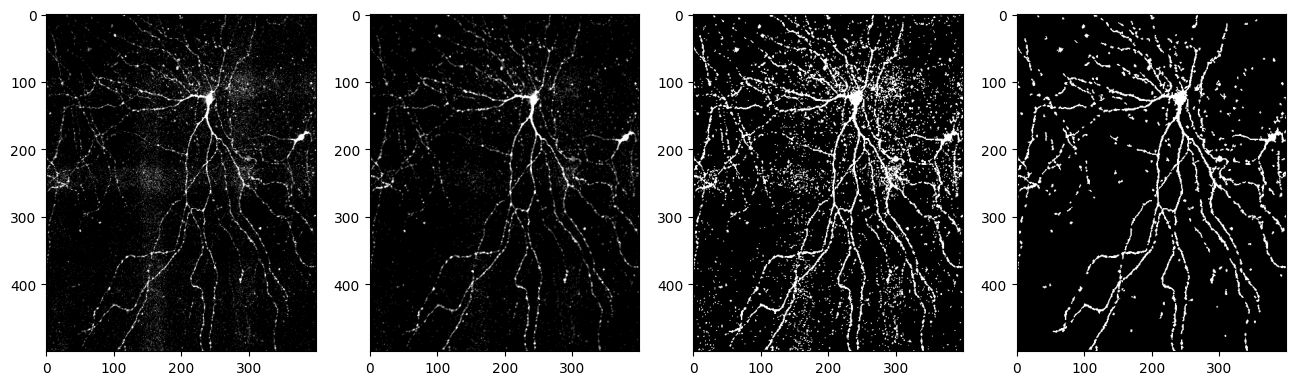

In [158]:
from readlif.reader import LifFile
import os
import numpy as np
import tifffile
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy import interpolate

channel = 1

f, ax = plt.subplots(1, 4, figsize=(16, 12))

input_path = r"C:\Users\Michael Forsthofer\OneDrive - University of Sussex\BadenLab\Anatomy\RGC tracings\66\250311\dorsomedial.tif"

zstack = tifffile.imread(input_path)
zstack = zstack[:, channel, :,:]
zstack = zstack[:, 1100:1600, 400:800]

interpolated_stack = resize(
    zstack, 
    (zstack.shape[0] * 2, 
     zstack.shape[1], 
     zstack.shape[2]),
    order=1,  # Bilinear interpolation
    preserve_range=True,
    mode='reflect'
).astype(zstack.dtype)

stack_mean = np.mean(interpolated_stack, axis=0)
processed_stack = interpolated_stack - stack_mean 

    # Ensure the data remains in the original dtype range
processed_stack = np.clip(processed_stack, 
                              np.iinfo(zstack.dtype).min, 
                              np.iinfo(zstack.dtype).max).astype(zstack.dtype)
ax[0].imshow(np.max(processed_stack, axis=0), cmap='gray', vmin = 2,vmax=9)

processed_stack = median_filter_3d(processed_stack, filter_size=2)

#plt.imshow(processed_stack[14,:,:], cmap='gray', vmin = 2,vmax=9)     

ax[1].imshow(np.max(processed_stack, axis=0), cmap='gray', vmin = 2,vmax=9)     

tifffile.imwrite("processed_stack.tif", processed_stack)

processed_stack = binarize_stack(processed_stack, min_threshold=2, max_threshold=255)

ax[2].imshow(np.max(processed_stack, axis=0), vmin = 0,vmax=1, cmap='gray')

(processed_stack, particles) = remove_small_particles(processed_stack, min_size=25)

ax[3].imshow(np.max(processed_stack, axis=0), vmin = 0,vmax=1, cmap='gray')

tifffile.imwrite("binarized_stack.tif", processed_stack)
